In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Make matplotlib plots bigger
plt.rcParams['figure.figsize'] = [15, 9]

First we need a way to open raw images. We will use the `rawpy` library with such settings that minimal processing is done on the image. Only debayering to a 16-bit linear image.

In [2]:
import rawpy

def open_raw_image(path: str) -> np.ndarray:
    with rawpy.imread(path) as raw:
        return np.float32(raw.postprocess(output_bps=16, user_flip=0, gamma=(1.0, 1.0), user_wb=[1.0, 1.0, 1.0, 1.0], output_color=rawpy.ColorSpace.raw, no_auto_bright=True)) / 65535.0


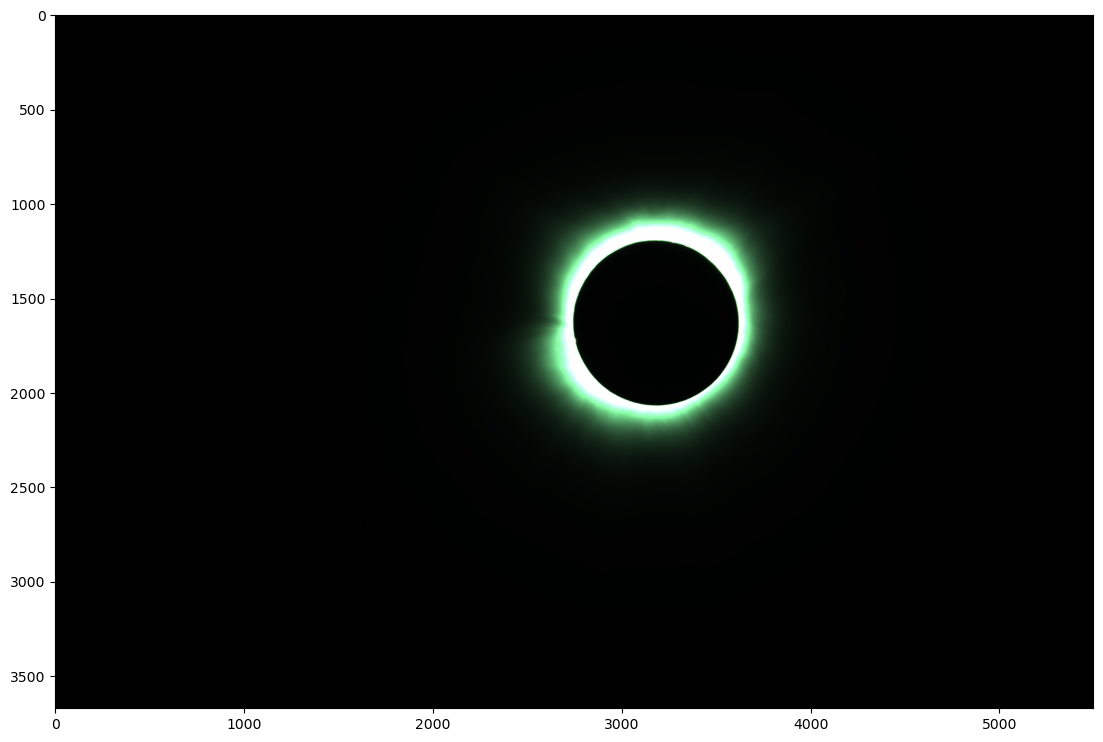

In [3]:
raw_image = open_raw_image(r'D:\Juttuja\EclipseAlignment\corona_images\7C0A4799.CR3')
plt.imshow(raw_image, vmin=0, vmax=1)
image_gray = np.mean(raw_image, axis=2)

We must mask out the edges of the image. Otherwise they will contribute to the frequency contents of the image when it is run through Fast Fourier Transform (FFT). We use a 2-dimensional Hann window as a mask. It will smoothly fade to black towards all edges, eliminating the edge.

(3670, 5496)


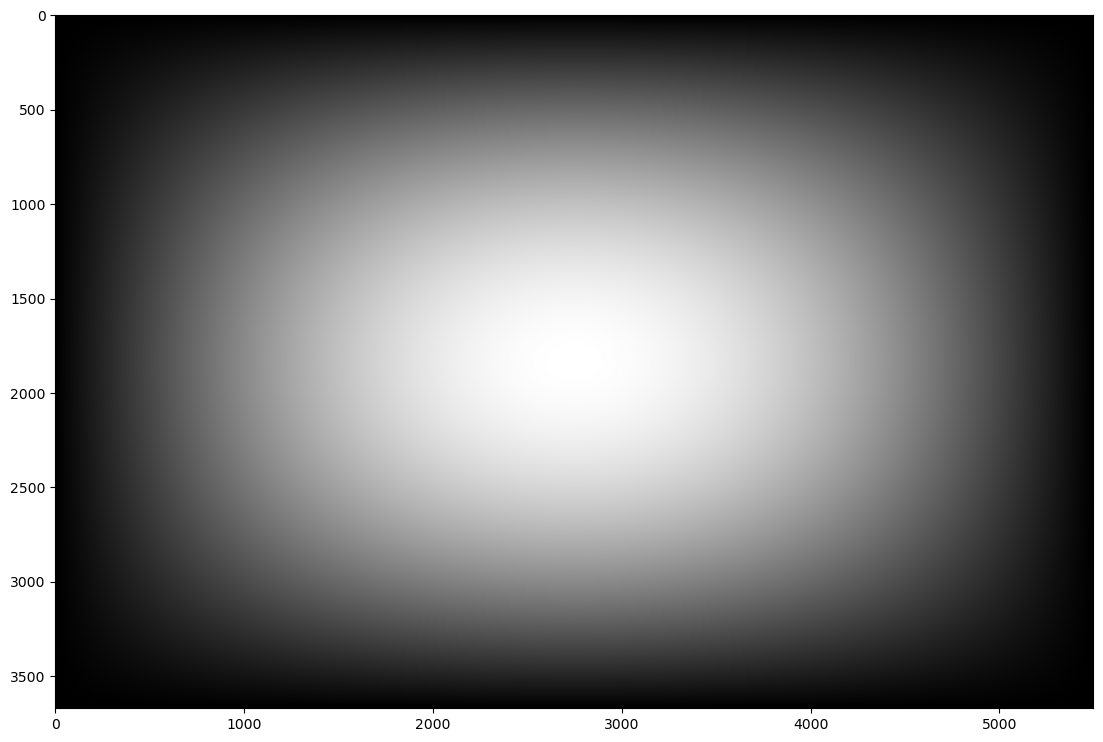

In [4]:
import cv2

window = cv2.createHanningWindow(image_gray.shape[::-1], cv2.CV_32F)
print(window.shape)
plt.imshow(window, cmap='gray', vmin=0, vmax=1)

Next we need to mask out the moon and the saturated part of the corona. To achieve this we must find the approximate center and radius of the moon in the image. We do this with the Hough Circle Transform from OpenCV.

Found circle: [1627.5 3178.5  435. ], image shape: (3670, 5496)


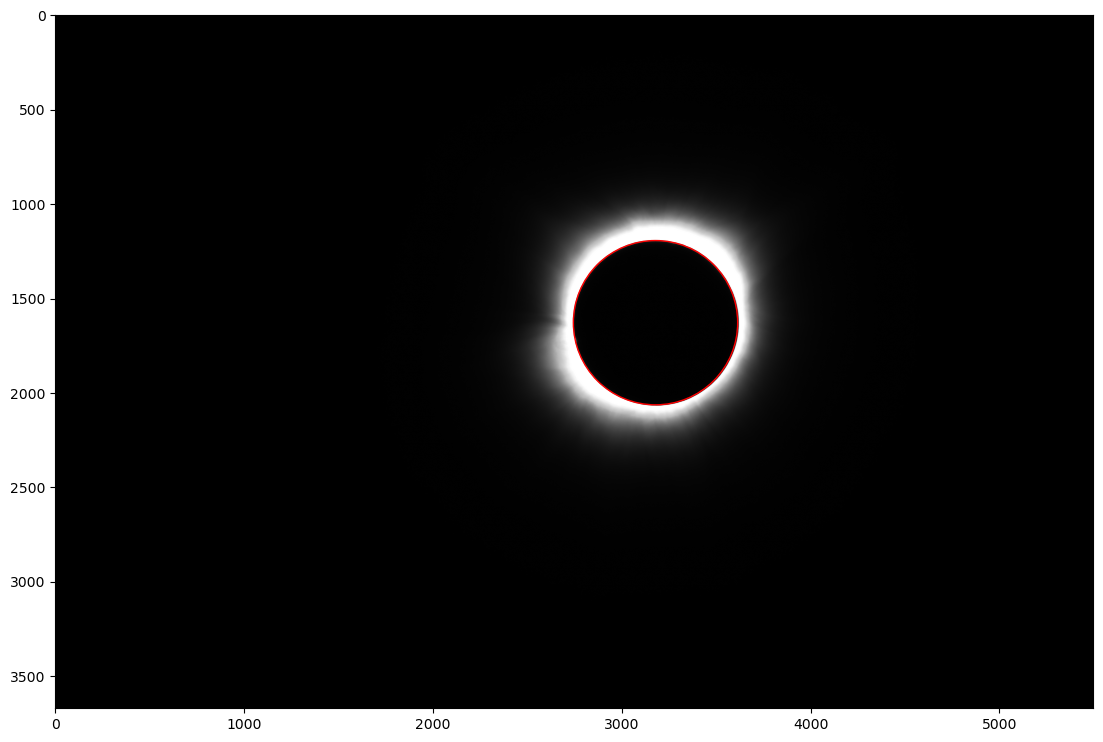

In [5]:
import cv2
import matplotlib.patches

def find_circle(image: np.ndarray, min_radius, max_radius) -> np.ndarray | None:
    image_8bit = (image * 255).astype(np.uint8)

    detected_circles = cv2.HoughCircles(image_8bit, cv2.HOUGH_GRADIENT, dp=3, minDist=image_8bit.shape[0]/16.0, param1=200, param2=100, minRadius=min_radius, maxRadius=max_radius)
    if detected_circles is not None:
        return detected_circles[0][0]
    else:
        return None

found_circle = find_circle(image_gray, min_radius=300, max_radius=700)
found_circle = np.array([found_circle[1], found_circle[0], found_circle[2]])
print(f"Found circle: {found_circle}, image shape: {image_gray.shape}")

plt.imshow(image_gray, vmin=0, vmax=1, cmap='gray')
plt.gca().add_patch(matplotlib.patches.Circle((found_circle[1], found_circle[0]), found_circle[2], fill=False, edgecolor='red'))

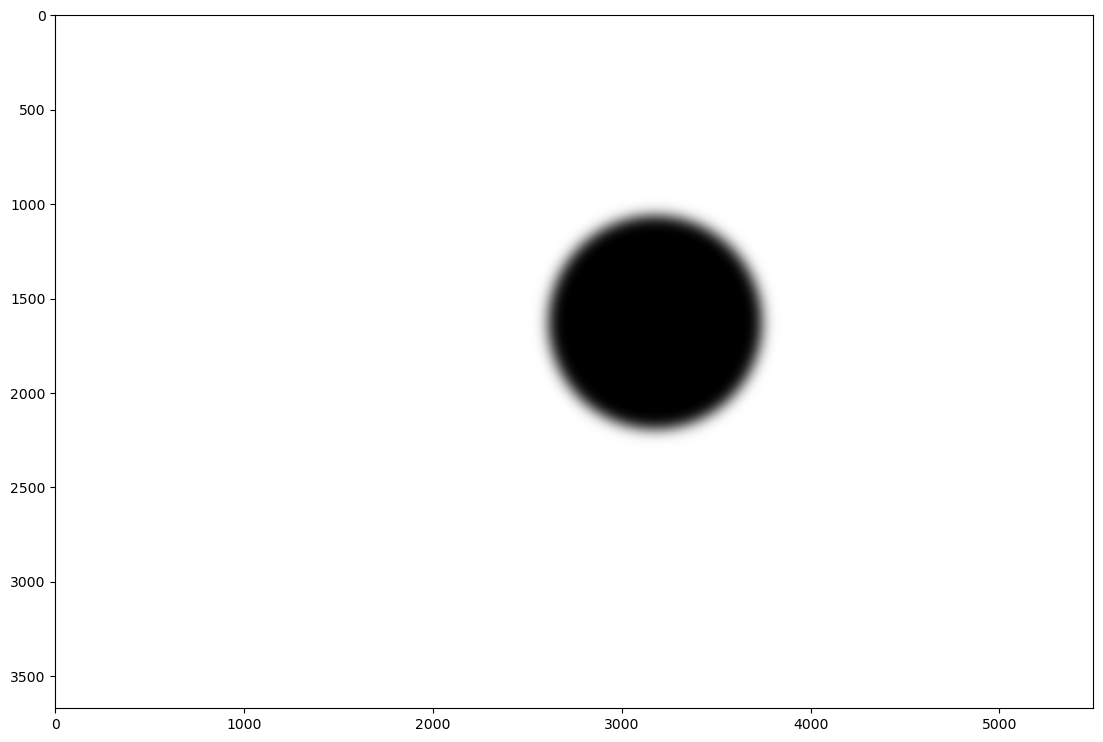

In [6]:
moon_mask = np.zeros_like(image_gray)
r = found_circle[2]
x = found_circle[1]
y = found_circle[0]
moon_radius_multiplier = 1.3
moon_mask = 1 - cv2.circle(moon_mask, (int(x), int(y)), int(moon_radius_multiplier * r), 1, thickness=-1)
moon_mask = cv2.GaussianBlur(moon_mask, (0, 0), sigmaX=moon_mask.shape[0] / 100, sigmaY=moon_mask.shape[0] / 100)
plt.imshow(moon_mask, cmap='gray', vmin=0, vmax=1)

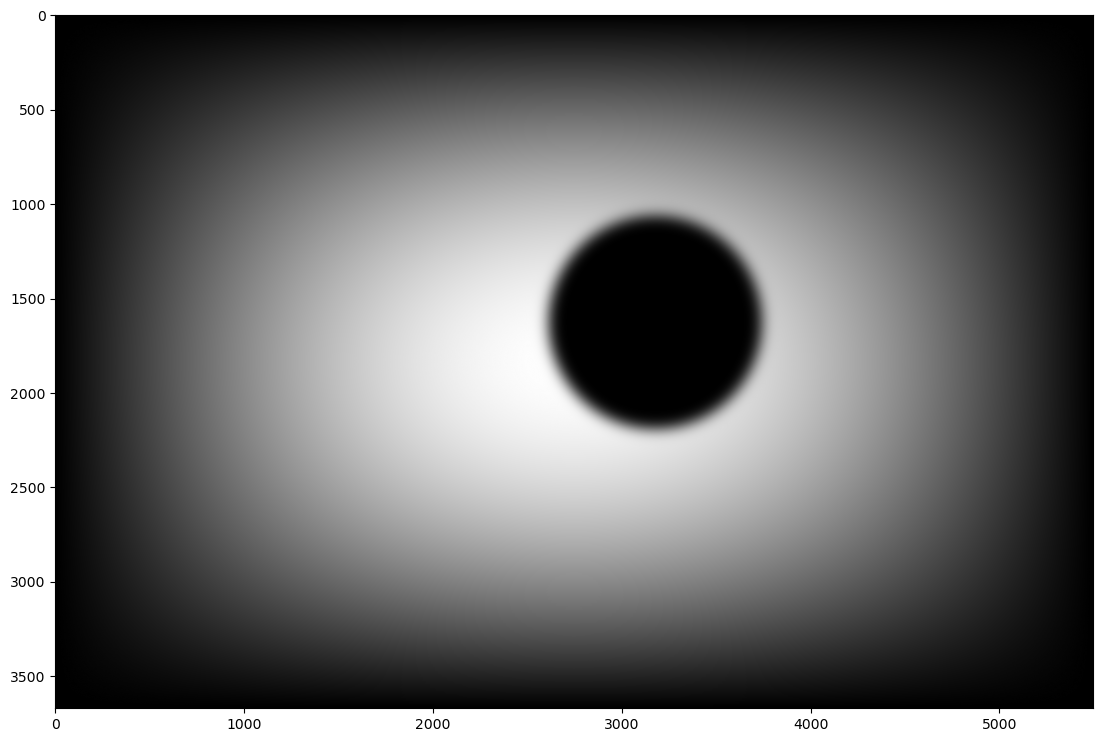

In [7]:
combined_mask = moon_mask * window
plt.imshow(moon_mask * window, cmap='gray', vmin=0, vmax=1)

The raw image must be high-pass filtered in a specific way to focus the alignment only on high-frequency coronal structures. The high-pass filtering must be done so that it removes radial low frequencies but retains tangential low frequencies. In practice we subtract a circularly blurred image from the original.

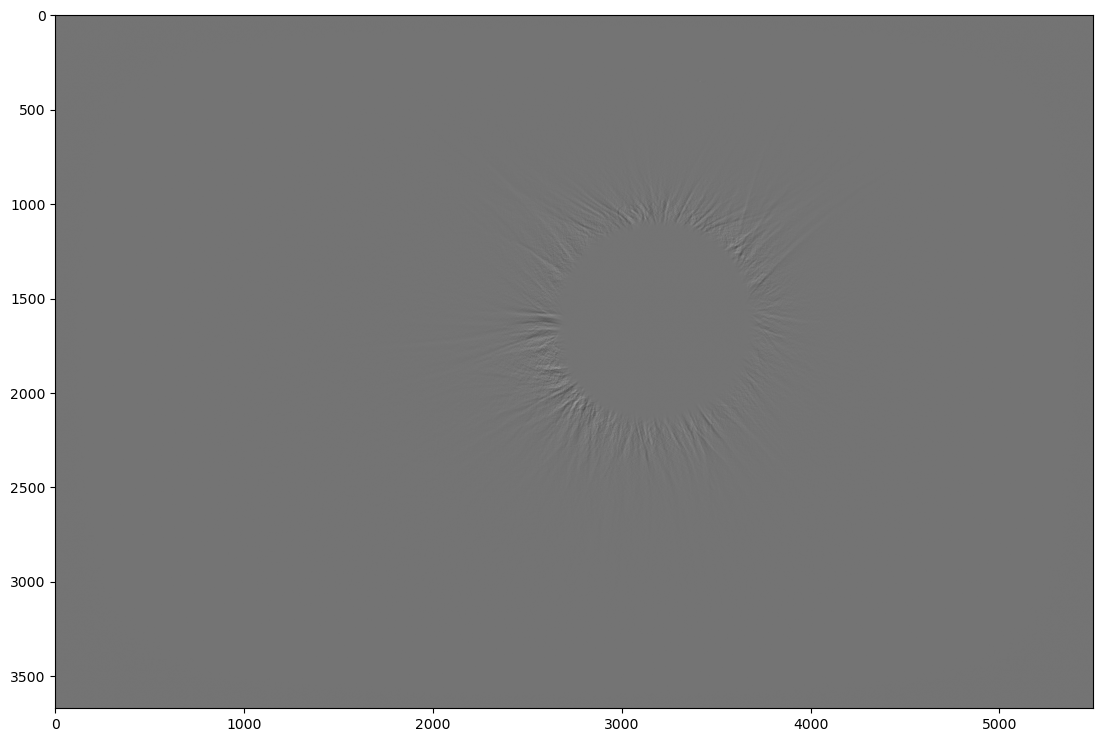

In [8]:
def rotational_blur(
    image: np.ndarray,
    num_steps: int,
    max_angle: float,
    center: tuple
) -> np.ndarray:
    """
    Apply a rotational blur to a grayscale image using rotation stacking.

    Parameters:
        image (np.ndarray): Input grayscale image (2D array).
        num_steps (int): Number of rotated images to average.
        max_angle (float): Maximum rotation angle in degrees (blur extent).
        center (tuple): (x, y) coordinates of the rotation center.

    Returns:
        np.ndarray: Blurred image.
    """
    assert image.ndim == 2, "Input image must be grayscale (2D array)."
    
    h, w = image.shape

    accumulator = np.zeros_like(image, dtype=np.float32)
    angles = np.linspace(-max_angle / 2.0, max_angle / 2.0, num_steps)

    for angle in angles:
        M = cv2.getRotationMatrix2D((center[1], center[0]), angle, 1.0)
        rotated = cv2.warpAffine(
            image, M, (w, h),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_REFLECT
        )
        accumulator += rotated.astype(np.float32)

    blurred = np.clip(accumulator / num_steps, 0.0, 1.0).astype(np.float32)
    return blurred

rot_angle = 2
hp_image = image_gray - rotational_blur(image_gray, num_steps=int(rot_angle*4), max_angle=rot_angle, center=(found_circle[0], found_circle[1]))
plt.imshow(combined_mask * hp_image, cmap='gray')

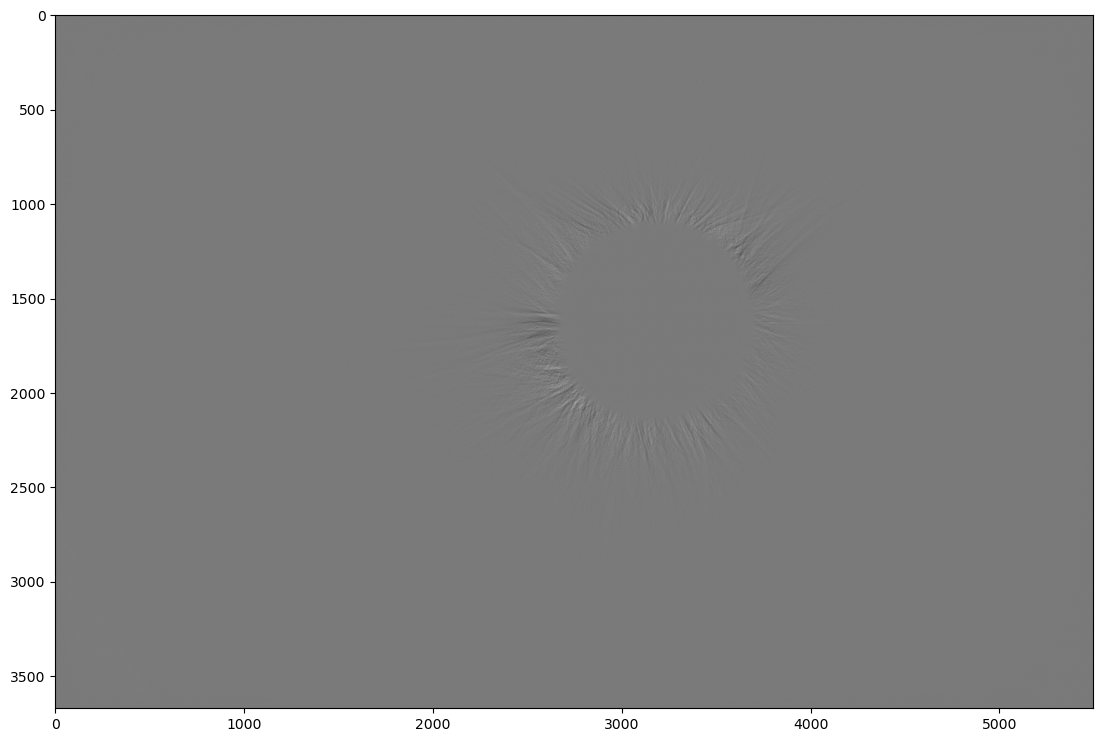

In [9]:
def rotational_blur_polar(
    image: np.ndarray,
    max_angle: float,
    center: tuple) -> np.ndarray:
    """    Apply a rotational blur to a grayscale image using polar coordinates.
    Parameters:
        image (np.ndarray): Input grayscale image (2D array).
        max_angle (float): Maximum rotation angle in degrees (blur extent).
        center (tuple): (x, y) coordinates of the rotation center.
    Returns:
        np.ndarray: Blurred image.
    """
    assert image.ndim == 2, "Input image must be grayscale (2D array)."
    h, w = image.shape

    max_radius = np.sqrt(((image.shape[0] / 2.0) ** 2.0) + ((image.shape[1] / 2.0) ** 2.0))
    polar_image = cv2.linearPolar(image, (center[1], center[0]), maxRadius=max_radius, flags=cv2.WARP_POLAR_LINEAR)
    blur_width = int(max_angle * polar_image.shape[0] / 360.0)
    blurred_polar = cv2.blur(polar_image, (1, blur_width))
    return cv2.linearPolar(blurred_polar, (center[1], center[0]), maxRadius=max_radius, flags=cv2.WARP_POLAR_LINEAR | cv2.WARP_INVERSE_MAP)

rot_angle_polar = 2
hp_image_polar = image_gray - rotational_blur_polar(image_gray, max_angle=rot_angle_polar, center=(found_circle[0], found_circle[1]))
plt.imshow(combined_mask * hp_image_polar, cmap='gray')